# 0. Magic Commands

ให้ใส่ไว้บนสุดทุก Notebook เป็นการสั่งให้ Notebook ก่อนรัน ให้รีโหลด Library ภายนอกที่เรา import ไว้ใหม่โดยอัตโนมัติ 

และให้พล็อตกราฟ matplotlib ใน Output ของ cell แบบ code ได้เลย

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# ! nvidia-smi

# 1. Install & Import Library

ติดตั้ง fastai2 หรือ fastai version 2 และ Import Library ที่เราจะใช้ 

เราจะต้อง Install kaggle เพื่อ Download Dataset

In [0]:
# Colab

! pip install kaggle --upgrade -q
! pip install fastai2 -q

Import 3 Package ย่อย คือ basics, vision.all, callback.all

การ import * หมายความว่า import ทุกอย่างที่อยู่ใน package ทำให้เราไม่ได้ต้องมา import ทีละ class การ import แบบนี้ เหมาะสำหรับการทดลองอะไรใหม่ ๆ เพราะเราไม่ต้องย้อนมาแก้ import ทุกครั้งเมื่อต้องการใช้ class ใหม่ ๆ แต่ไม่แนะนำสำหรับใช้งานจริงบน Production


In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastai2.callback.cutmix import CutMix

เราจะกำหนด Random Seed จะได้ผลลัพธ์ที่เหมือนกันทุกครั้ง จะได้สะดวกในการเปรียบเทียบ

In [0]:
np.random.seed(42)

# 2. เตรียม Path สำหรับดาวน์โหลดข้อมูล

กำหนด path ของ Config File และ Dataset ว่าจะอยู่ใน Google Drive ถ้าเราใช้ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) หรือ อยู่ใน HOME ถ้าเราใช้ VM ธรรมดา และกำหนด Environment Variable ไปยังโฟลเดอร์ที่เก็บ kaggle.json

ในกรณีใช้ Colab ให้ Mount Google Drive เพื่อดึง Config File มาจาก Google Drive ส่วนตัวของเรา เมื่อเรารัน Cell ด้านล่างจะมีลิงค์ปรากฎขึ้นมาให้เรา Login กด Approve แล้ว Copy Authorization Code มาใส่ในช่องด้านล่าง แล้วกด Enter

In [7]:
dataset = 'kmader/skin-cancer-mnist-ham10000'

# Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/datasets/')

data_path = data_path_base/dataset

from google.colab import drive
drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

# # VM
# config_path = Path(os.getenv("HOME"))
# data_path = config_path/"datasets"/dataset

# data_path.mkdir(parents=True, exist_ok=True)
# os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/.kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Dataset

ในเคสนี้ เราจะ Download ข้อมูล Dataset ที่เกี่ยวข้องทั้งหมดมาเก็บไว้ แบ่งเป็นรูปถ่ายโรคมะเร็งผิวหนังต่าง ๆ 

Dataset เราจะดึงจาก Kaggle วิธี Download kaggle.json ให้ดูจาก ep ที่แล้ว

เมื่อได้ kaggle.json มาแล้ว ในกรณีใช้ Google Colab ให้นำมาใส่ไว้ในโฟลเดอร์ My Drive/.kaggle ใน Google Drive ของเรา เป็น My Drive/.kaggle/kaggle.json ถ้าใช้ VM ให้ใส่ใน HOME/.kaggle/

สั่งดาวน์โหลด Dataset จาก Kaggle พร้อมทั้ง unzip ไว้ใน data_path

In [0]:
# !kaggle datasets download {dataset} -p "{data_path}" --unzip

ดูว่าแตก zip มาได้ไฟล์อะไรบ้าง 

In [9]:
data_path.ls()

(#9) [Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/ham10000_images_part_1'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/HAM10000_images_part_2'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/HAM10000_images_part_1'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/ham10000_images_part_2'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv')]

In [0]:
# (data_path/"ham10000_images_part_1").ls()

ย้ายข้อมูลรูปภาพไปไว้ Folder เดียวกัน จะได้สะดวก

In [0]:
! mv {(data_path/"ham10000_images_part_2")}/* {(data_path/"ham10000_images_part_1")}

# 4. Data

อ่านไฟล์ CSV ขึ้นมา ดูข้อมูลเพิ่มเติม เช่น Label

In [0]:
csv_file = data_path/"HAM10000_metadata.csv"

Label อยู่ใน Column dx เป็นตัวย่อ

In [16]:
df = pd.read_csv(csv_file)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


สร้าง Dict ตัวย่อ เป็น คำแปล ชื่อหมวดหมู่ของโรค

In [0]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

เอามา Map ลง Dataframe เพื่อใช้เป็น Label

In [18]:
df.dx = df.dx.astype('category', copy=True)
df['labels'] = df.dx.cat.codes 
df['lesion'] = df.dx.map(lesion_type_dict)
df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,labels,lesion
3697,HAM_0005218,ISIC_0028939,nv,follow_up,55.0,female,lower extremity,5,Melanocytic nevi
7213,HAM_0007444,ISIC_0033989,nv,histo,50.0,female,lower extremity,5,Melanocytic nevi
310,HAM_0002839,ISIC_0032280,bkl,histo,60.0,female,lower extremity,2,Benign keratosis
4438,HAM_0005070,ISIC_0030863,nv,follow_up,55.0,female,trunk,5,Melanocytic nevi
6087,HAM_0005969,ISIC_0028257,nv,follow_up,35.0,male,abdomen,5,Melanocytic nevi


นับจำนวนข้อมูลแต่ละ Class

In [19]:
df.lesion.value_counts()

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64

# 5. Data Pipeline

กำหนด Data Pipeline ในการแปลงข้อมูลก่อน Feed เข้าสู่ Model

กำหนด Batch Size

In [0]:
bs = 64

Transform แต่ละรูป ด้วยการ สุ่มย่อ แล้ว Crop ให้ได้ขนาดเท่ากันทุกรูป เพื่อจัดเข้า Batch

In [0]:
item_tfms = RandomResizedCrop(420, min_scale=0.7, ratio=(1., 1.))

ทำ Data Augmentation ทำ Transform ทีละ Batch ด้วย GPU แล้ว Normalize

In [0]:
batch_tfms = [*aug_transforms(size=360, max_rotate=300., flip_vert=True, max_warp=0.), Normalize()]

สร้าง DataBlock กำหนดค่าต่าง ๆ ใน Data Pipeline

In [0]:
cancer = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_x=ColReader('image_id', pref=f'{data_path}/ham10000_images_part_1/', suff='.jpg'), 
                 get_y=ColReader('lesion'), 
                 splitter=RandomSplitter(), 
                 item_tfms=item_tfms, 
                 batch_tfms=batch_tfms)

In [0]:
# cancer.summary(df)

สร้าง DataLoaders จาก DataBlock

In [0]:
dls = cancer.dataloaders(df, bs=bs)

แสดงตัวอย่าง ข้อมูล 1 Batch

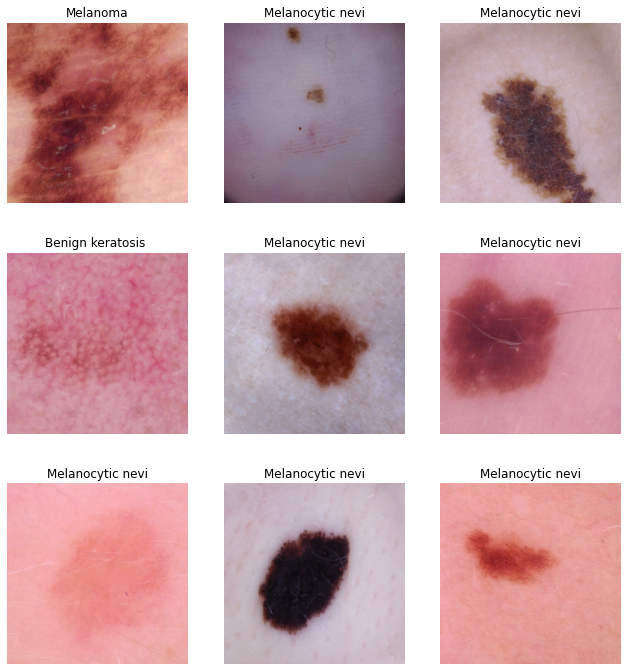

In [30]:
dls.show_batch(max_n=9, figsize=(11, 12))

ดูใน vocab Dictionary มี 7 Class

In [31]:
dls.vocab

(#7) ['Actinic keratoses','Basal cell carcinoma','Benign keratosis ','Dermatofibroma','Melanocytic nevi','Melanoma','Vascular lesions']

# 6. Model 

เราจะใช้โมเดล Architecture ResNet50 เทรนแบบ Mixed Precision 

In [32]:
learn = cnn_learner(dls, resnet50, pretrained=True, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
# LabelSmoothingCrossEntropy??
# CutMix??

In [0]:
# learn = Learner(dls, xresnet50(n_out=7), metrics=error_rate, 
#                 loss_func=LabelSmoothingCrossEntropy(), 
#                 cbs=[ShowGraphCallback, CutMix(alpha=1.)], 
#                 ).to_fp16()
# learn

# 7. Train

เรียก Fine-tune ให้ Learner เทรนแบบ Head 1 Epoch และ เทรนต่อทั้งโมเดล

In [35]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.584700,0.868420,0.234354,02:37


epoch,train_loss,valid_loss,error_rate,time
0,0.829482,0.589420,0.171771,02:36
1,0.684667,0.503521,0.162450,02:33
2,0.564766,0.429181,0.130493,02:32
3,0.474884,0.393500,0.128495,02:31
4,0.396195,0.382315,0.131824,02:31
5,0.320704,0.320051,0.111185,02:30
6,0.258116,0.298827,0.097870,02:31
7,0.217655,0.285996,0.099201,02:30
8,0.158396,0.260878,0.079893,02:30
9,0.142355,0.262141,0.083888,02:30


ได้ Error Rate 0.09 หรือ Accuracy ประมาณ 91%

# 8. ดูผลลัพธ์

ถ้าเราดูแค่ Metrics Error Rate อย่างเดียว ว่ากี่เปอร์เซ็นต์ เราอาจจะไม่เห็นภาพว่า Model ทำงานได้ผลลัพธ์อย่างไร เราควรดูข้อมูลจริง รูปจริง Label จริง ด้วย ว่าโมเดล Predict อะไรออกมา

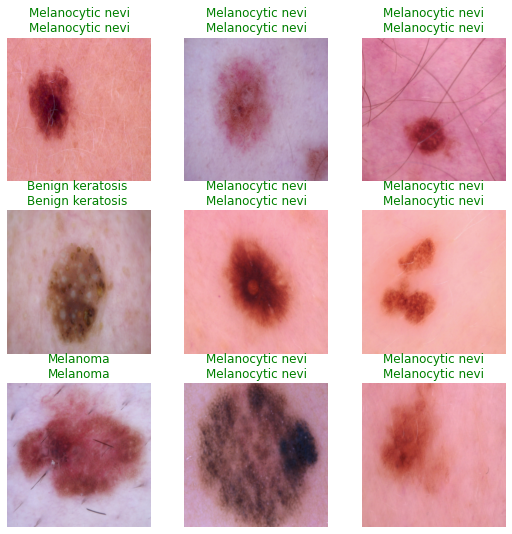

In [37]:
learn.show_results()

เราจะสร้าง ClassificationInterpretation เป็น class ที่มาช่วยตีความผลลัพธ์ ให้เราดูเข้าใจง่ายขึ้น

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

len(dls.valid_ds) == len(losses) == len(idxs)

True

เราจะดูรูปที่มีค่า Loss มากที่สุด 9 อันดับแรก หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายผิด Class ด้วยความมั่นใจ (Probability) มากที่สุด 9 อันดับแรก

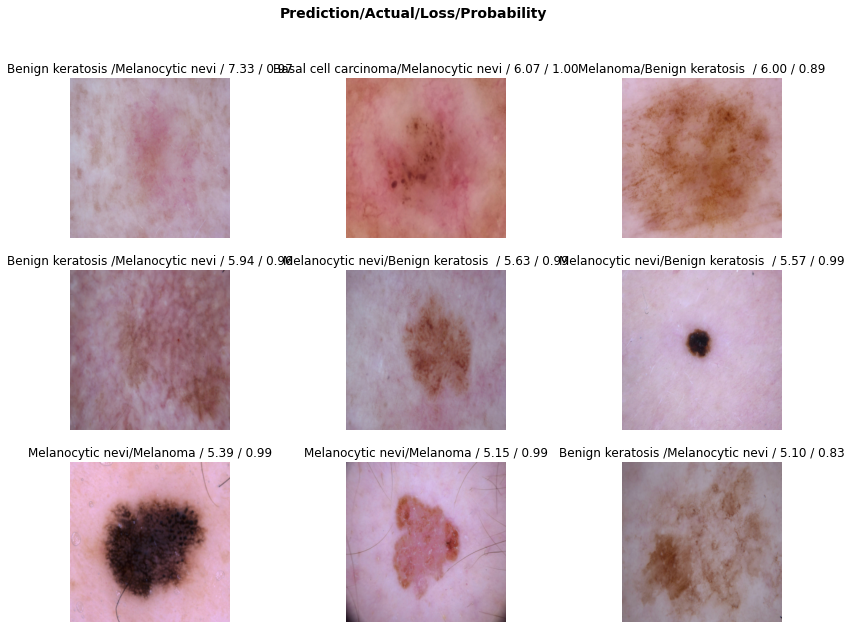

In [39]:
interp.plot_top_losses(9, figsize=(14, 10))

สั่ง plot_confusion_matrix จะแสดงตาราง [Confusion Matrix](https://www.bualabs.com/archives/1968/what-is-confusion-matrix-what-is-metrics-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) ตัดกันของหมวดหมู่ทั้งหมด 7 x 7 ว่าข้อมูลจริงคือโรคอะไร (Row) แล้วโมเดลทายว่าโรคอะไร (Column) สังเกตุที่ทายถูกจะเป็นเส้นแทยงมุมตรงกลาง

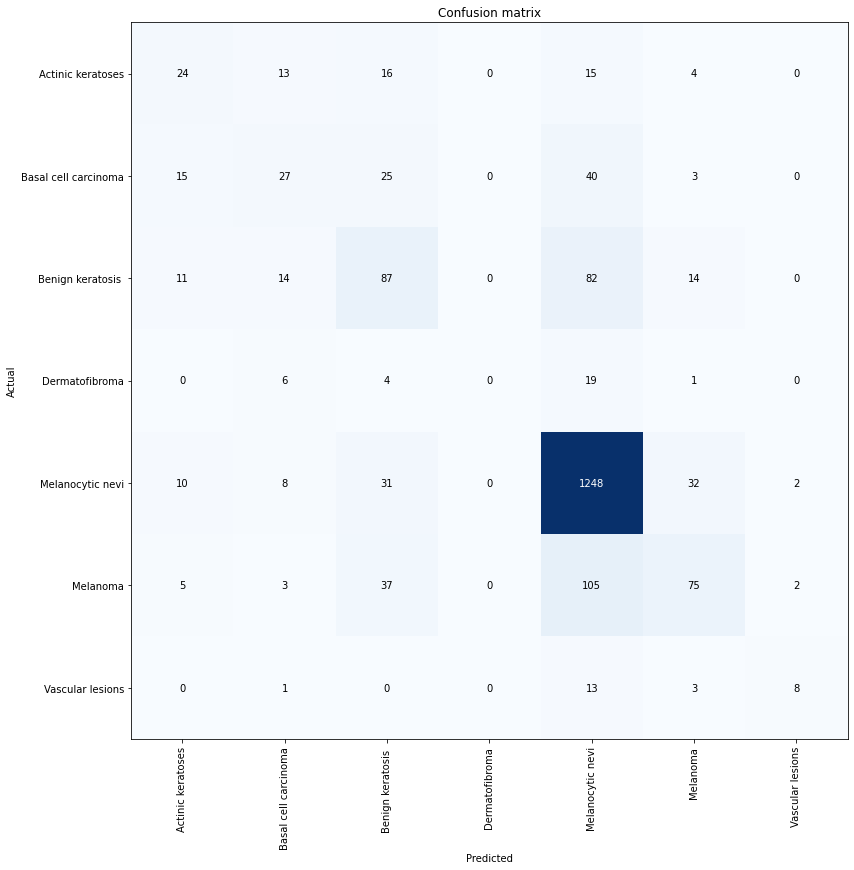

In [29]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=72)

เรียกดู most_confused คือ โรคที่โมเดลทายผิดมากที่สุดเรียงลงไป

In [40]:
interp.most_confused(min_val=3)

[('Melanoma', 'Melanocytic nevi', 36),
 ('Benign keratosis ', 'Melanocytic nevi', 14),
 ('Melanocytic nevi', 'Benign keratosis ', 14),
 ('Melanocytic nevi', 'Melanoma', 13),
 ('Benign keratosis ', 'Melanoma', 11),
 ('Melanoma', 'Benign keratosis ', 8),
 ('Actinic keratoses', 'Benign keratosis ', 6),
 ('Basal cell carcinoma', 'Melanocytic nevi', 6),
 ('Actinic keratoses', 'Basal cell carcinoma', 3),
 ('Basal cell carcinoma', 'Benign keratosis ', 3)]